In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

print("TensorFlow version:", tf.__version__)

2025-11-15 15:47:47.588068: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-15 15:47:47.636868: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-15 15:47:47.996710: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-15 15:47:47.998708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-15 15:47:49.292667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

TensorFlow version: 2.13.1


In [3]:
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

In [4]:
path_to_train_file = tf.keras.utils.get_file(
    'train.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt'
)
path_to_test_file = tf.keras.utils.get_file(
    'test.txt',
    'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt'
)

train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8')
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

print('Length of train text: {} characters'.format(len(train_text)))
print('Length of test text: {} characters'.format(len(test_text)))
print(train_text[:300]) 

Length of train text: 6937271 characters
Length of test text: 2318260 characters
id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


In [5]:
train_Y = np.array([
    [int(row.split('\t')[2])]
    for row in train_text.split('\n')[1:]
    if row.count('\t') > 0
])

test_Y = np.array([
    [int(row.split('\t')[2])]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
])

print("train_Y shape:", train_Y.shape)
print("test_Y shape:", test_Y.shape)
print("train_Y sample:", train_Y[:5])

train_Y shape: (150000, 1)
test_Y shape: (50000, 1)
train_Y sample: [[0]
 [1]
 [0]
 [0]
 [1]]


In [6]:
import re

def clean_str(string):    
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]
# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [7]:
VOCAB_SIZE = 2000   # 단어 사전 크기
MAX_LEN = 25        # 최대 문장 길이 (패딩 기준)

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',  # 소문자 변환 + 구두점 제거
    split='whitespace',                         # 띄어쓰기 기준 토큰화
    max_tokens=VOCAB_SIZE,                      # 단어 사전 크기
    output_mode='int',                          # 정수 인코딩
    output_sequence_length=MAX_LEN              # 자동 패딩
)

vectorize_layer.adapt(train_text_X)  # 단어 사전 학습
# 텍스트를 정수 시퀀스로 변환 (패딩 포함)
train_X = vectorize_layer(train_text_X)

print(train_X[:5])

tf.Tensor(
[[  23  902    5    1 1097    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [ 586    1    1    1    1    1    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1   68  345   28   33    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]
 [   1    1  102    1    2    1    1  844    1    1  570    1    0    0
     0    0    0    0    0    0    0    0    0    0    0]], shape=(5, 25), dtype=int64)


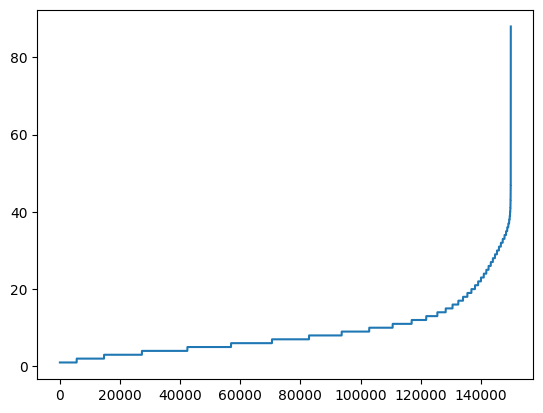

142587


In [8]:
import matplotlib.pyplot as plt
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()
plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len]))

In [9]:
test_text_X = [
    row.split('\t')[1]
    for row in test_text.split('\n')[1:]
    if row.count('\t') > 0
]

# Week1에서 학습된 vectorize_layer 그대로 사용합니다.
test_X = vectorize_layer(test_text_X)

print("test_X shape:", test_X.shape)
print("test_Y shape:", test_Y.shape)


test_X shape: (50000, 25)
test_Y shape: (50000, 1)


In [10]:
# 모델의 주요 설정값들을 미리 정의해줍니다.
VOCAB_SIZE = 2000
EMBEDDING_DIM = 128
MAX_LEN = 25
EPOCHS = 10
BATCH_SIZE = 32

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_shape=(MAX_LEN,)),
    tf.keras.layers.GlobalAveragePooling1D(), #입력층
    tf.keras.layers.Dense(64, activation='relu'), #은닉층
    tf.keras.layers.Dense(1, activation='sigmoid') #출력층
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 128)           256000    
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 264321 (1.01 MB)
Trainable params: 264321 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(
    train_X, train_Y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.4929 - accuracy: 0.7318 - val_loss: 0.4577 - val_accuracy: 0.7603
Epoch 2/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.4581 - accuracy: 0.7537 - val_loss: 0.4634 - val_accuracy: 0.7538
Epoch 3/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.4514 - accuracy: 0.7565 - val_loss: 0.4547 - val_accuracy: 0.7600
Epoch 4/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.4459 - accuracy: 0.7595 - val_loss: 0.4551 - val_accuracy: 0.7601
Epoch 5/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.4424 - accuracy: 0.7606 - val_loss: 0.4573 - val_accuracy: 0.7592
Epoch 6/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.4377 - accuracy: 0.7643 - val_loss: 0.4557 - val_accuracy: 0.7606
Epoch 7/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.4324 - accuracy: 0.7680 - val_loss: 0.4563 - val_ac

In [14]:
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.4894, Test Accuracy: 0.7419


In [15]:
example_sentences = [
    "이 영화 진짜 재미있어요",
    "완전 지루하고 별로였음",
    "배우 연기는 좋았지만 스토리가 아쉬웠다"
]

example_seq = vectorize_layer(example_sentences)
pred = model.predict(example_seq)

for s, p in zip(example_sentences, pred):
    print(f"문장: {s}")
    print(f"긍정 확률: {p[0]:.4f}")
    print("결과:", "긍정 😊" if p[0] > 0.5 else "부정 😞")

1/1 [==============================] - 0s 50ms/step
문장: 이 영화 진짜 재미있어요
긍정 확률: 0.9885
결과: 긍정 😊
문장: 완전 지루하고 별로였음
긍정 확률: 0.0188
결과: 부정 😞
문장: 배우 연기는 좋았지만 스토리가 아쉬웠다
긍정 확률: 0.0089
결과: 부정 😞


In [16]:
history2 = model.fit(
    train_X, train_Y,
    epochs=30,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
3750/3750 [==============================] - 11s 3ms/step - loss: 0.4155 - accuracy: 0.7782 - val_loss: 0.4729 - val_accuracy: 0.7583
Epoch 2/30
3750/3750 [==============================] - 11s 3ms/step - loss: 0.4120 - accuracy: 0.7804 - val_loss: 0.4753 - val_accuracy: 0.7527
Epoch 3/30
3750/3750 [==============================] - 11s 3ms/step - loss: 0.4087 - accuracy: 0.7810 - val_loss: 0.4768 - val_accuracy: 0.7539
Epoch 4/30
3750/3750 [==============================] - 11s 3ms/step - loss: 0.4051 - accuracy: 0.7841 - val_loss: 0.4820 - val_accuracy: 0.7576
Epoch 5/30
3750/3750 [==============================] - 11s 3ms/step - loss: 0.4015 - accuracy: 0.7871 - val_loss: 0.4855 - val_accuracy: 0.7509
Epoch 6/30
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3984 - accuracy: 0.7883 - val_loss: 0.4911 - val_accuracy: 0.7523
Epoch 7/30
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3950 - accuracy: 0.7907 - val_loss: 0.4938 - val_ac

In [17]:
test_loss, test_acc = model.evaluate(test_X, test_Y, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.6545, Test Accuracy: 0.7138


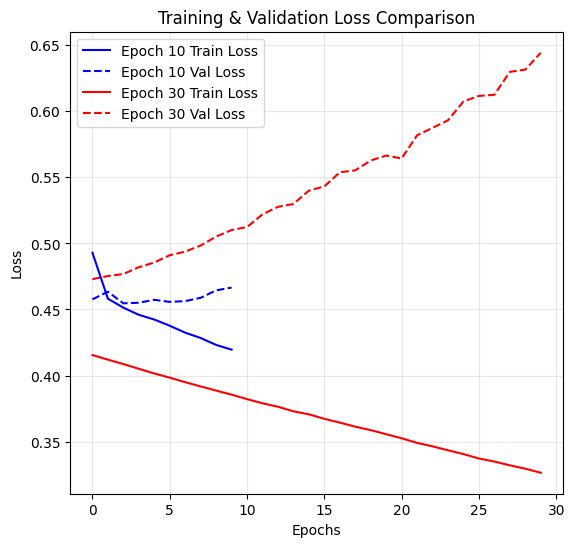

In [27]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1) # 1행 2열 중 첫 번째
# Epoch 10 (파란색 계열)
plt.plot(history.history['loss'], 'b-', label='Epoch 10 Train Loss')
plt.plot(history.history['val_loss'], 'b--', label='Epoch 10 Val Loss')
# Epoch 30 (빨간색 계열)
plt.plot(history2.history['loss'], 'r-', label='Epoch 30 Train Loss')
plt.plot(history2.history['val_loss'], 'r--', label='Epoch 30 Val Loss')

plt.title('Training & Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3) # 격자 추가

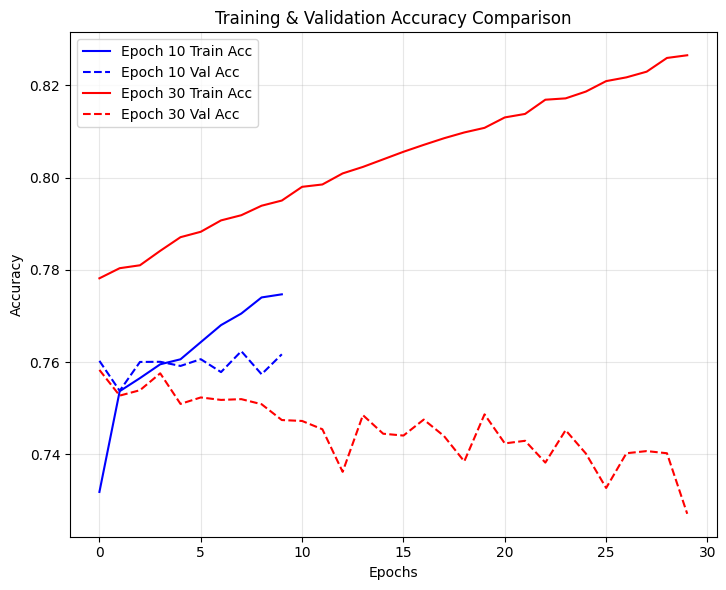

In [29]:
plt.figure(figsize=(14, 6))
# 2. Accuracy 그래프 (오른쪽)
plt.subplot(1, 2, 2) # 1행 2열 중 두 번째
# Epoch 10
plt.plot(history.history['accuracy'], 'b-', label='Epoch 10 Train Acc')
plt.plot(history.history['val_accuracy'], 'b--', label='Epoch 10 Val Acc')
# Epoch 30
plt.plot(history2.history['accuracy'], 'r-', label='Epoch 30 Train Acc')
plt.plot(history2.history['val_accuracy'], 'r--', label='Epoch 30 Val Acc')

plt.title('Training & Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout() # 그래프 간 간격 자동 조절
plt.show()